In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install face-recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 25 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=76948114fb1a8c465ca904915fd0fc12a4112d2d5cd04025f42805e400baaa1e
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
pip install pygobject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical5
from tensorflow.keras.optimizers import Adam
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tensorflow import keras
import face_recognition
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import cv2
import os

#Parameters

In [ ]:
batch_size_val = 80  # how many to process together
epochs_val = 100
noOfClasses=2
imageDimensions = (80, 80,3) 
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

In [ ]:
# FUNCTION FOR LOADING IMAGES
def load_images_from_folder(folder, eyes = 0):
    count = 0
    error_count = 0
    images = []
    for filename in os.listdir(folder):
        try:
            img = cv2.imread(os.path.join(folder,filename))
            img = cv2.resize(img, (80,80)) ## Resizing the images
            ## for eyes if it is 0: open, 1: close
            images.append([img, eyes])
        except:
            error_count += 1
            print('ErrorCount = ' + str(error_count))
            continue
        
        count += 1
        if count % 1000 == 0:
            print('Succesful Image Import Count = ' + str(count))

    return images

# Open eyes

In [ ]:
open_img = r'/content/drive/MyDrive/Colab Notebooks/CROPPED/OPEN'

folder = open_img

open_eyes = load_images_from_folder(folder, 0)

Succesful Image Import Count = 1000
Succesful Image Import Count = 2000


# Close eyes

In [ ]:
close_img = r'/content/drive/MyDrive/Colab Notebooks/CROPPED/CLOSE'
folder = close_img
closed_eyes = load_images_from_folder(folder, 1)

Succesful Image Import Count = 1000
Succesful Image Import Count = 2000


In [ ]:
eyes = closed_eyes + open_eyes

In [ ]:
X = [] # IMAGES
y = [] # LABELS
for features, label in eyes: 
    X.append(features)
    y.append(label)
    
# NUMPY ARRAY CONVERTION
images=np.array(X)    
labels=np.array(y)

print("Total Images",len(X))  

Total Images 4382


# DATA SPLITTING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images,labels, test_size=testRatio)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [ ]:
# TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET

print("Data Shapes")
print("Train", end="")
print(X_train.shape, y_train.shape)
print("Validation", end="")
print(X_validation.shape, y_validation.shape)
print("Test", end="")
print(X_test.shape, y_test.shape)
assert (X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert (X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert (X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert (X_train.shape[1:]==(imageDimensions))," The dimesions of the Training images are wrong "
assert (X_validation.shape[1:]==(imageDimensions))," The dimesionas of the Validation images are wrong "
assert (X_test.shape[1:]==(imageDimensions))," The dimesionas of the Test images are wrong"

Data Shapes
Train(2804, 80, 80, 3) (2804,)
Validation(701, 80, 80, 3) (701,)
Test(877, 80, 80, 3) (877,)


# DATA AUGMENTATION

In [ ]:
print("X_train shape before gray",X_train.shape)

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img


X_train = np.array(list(map(preprocessing, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
print("X_train shape after gray",X_train.shape)


# ADDING A DEPTH OF 1 (grayscale)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
print("X_train shape after depth",X_train.shape)


# AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES

dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)


#One hot encoding
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

X_train shape before gray (2804, 80, 80, 3)
X_train shape after gray (2804, 80, 80)
X_train shape after depth (2804, 80, 80, 1)


# MODEL

In [ ]:
def my_Model():   
    
    # Instantiate the model
    model = Sequential()

    # Adding first three convolutional layers
    model.add(Conv2D( 
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu',
                    input_shape = (imageDimesions[0],imageDimesions[1],1) # shape of input (image)
                    ))
    model.add(Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    model.add(Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    
    # Adding pooling after convolutional layers
    model.add(MaxPooling2D(pool_size = (2,2))) # Dimensions of the region that you are pooling

    # Adding second set of convolutional layers
    model.add(Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    model.add(Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    
    # Add last pooling layer.
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    # Adding first dense layer with 256 nodes
    model.add(Dense(256, activation='relu'))

    # Adding a dropout layer to avoid overfitting
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3)) 

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # adding output layer
    model.add(Dense(2, activation = 'sigmoid'))

    # compiling the model
    model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# TRAINING

In [ ]:
model = my_Model()
print(model.summary())
# FITTING
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),steps_per_epoch= len(X_train)//batch_size_val, epochs=epochs_val,validation_data=(X_validation, y_validation), shuffle=1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 78, 78, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 76, 76, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 74, 74, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 35, 35, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 33, 33, 32)        9248      
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Epoch 1/100
35/35 [==============================] - 5s 112ms/step - loss: 0.6699 - accuracy: 0.5639 - val_loss: 0.5410 - val_accuracy: 0.7475
Epoch 2/100
35/35 [==============================] - 2s 67ms/step - loss: 0.5715 - accuracy: 0.7300 - val_loss: 0.4921 - val_accuracy: 0.7946
Epoch 3/100
35/35 [==============================] - 2s 65ms/step - loss: 0.4944 - accuracy: 0.7797 - val_loss: 0.3158 - val_accuracy: 0.8759
Epoch 4/100
35/35 [==============================] - 2s 65ms/step - loss: 0.4068 - accuracy: 0.8289 - val_loss: 0.2871 - val_accuracy: 0.8816
Epoch 5/100
35/35 [==============================] - 2s 65ms/step - loss: 0.3418 - accuracy: 0.8590 - val_loss: 0.2282 - val_accuracy: 0.9230
Epoch 6/100
35/35 [==============================] - 2s 65ms/step - loss: 0.3487 - accuracy: 0.8572 - val_loss: 0.2215 - val_accuracy: 0.9201
Epoch 7/100
35/35 [==============================] - 2s 65ms/step - loss: 0.3370 - accuracy: 0.8594 - val_loss: 0.2176 - val_accuracy: 0.9130


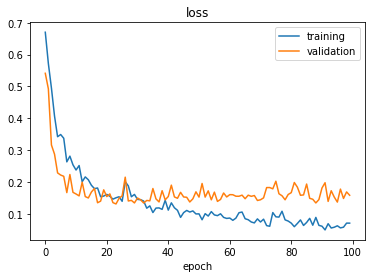

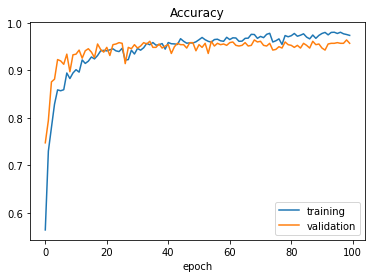

In [ ]:
# PLOT
plt.figure(0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')


plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print('Test Score:', score[0])
print('Test Accuracy:', score[1])

28/28 [==============================] - 0s 13ms/step - loss: 0.1185 - accuracy: 0.9704
Test Score: 0.11851533502340317
Test Accuracy: 0.9703534841537476


In [ ]:
model.save('drowsiness_check.h5')